In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Embedding
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
NUM_SENTENCES = 50000 
MAX_NUM_WORDS = 50000
MAX_SENT_LEN = 50

EMBEDDING_SIZE = 100

LSTM_NEURONS = 100

BATCH_SIZE = 16
EPOCHS = 20

In [3]:
path_en = r"C:\Users\aredd\Desktop\NMT\data\raw\small_vocab_en.txt"
path_fr = r"C:\Users\aredd\Desktop\NMT\data\raw\small_vocab_fr.txt"

with open(path_en, 'r', encoding='utf-8') as f_en:
    inputs = f_en.readlines()

with open(path_fr, 'r', encoding='utf-8') as f_fr:
    outputs = f_fr.readlines()
    
inputs = [word.strip() for word in inputs]
outputs_i = ['<sos> ' + word.strip() for word in outputs]
outputs = [word.strip() + ' <eos>' for word in outputs]

In [4]:
# taking first N 
inputs = inputs[:NUM_SENTENCES]
outputs_i = outputs_i[:NUM_SENTENCES] 
outputs = outputs[:NUM_SENTENCES] 

In [5]:
len(inputs),len(outputs),len(outputs_i)

(50000, 50000, 50000)

In [6]:
print('Total inputs =', len(inputs))
print('Total intermediate outputs =', len(outputs_i))
print('Total outputs =', len(outputs))
print('\nSample:')
print(inputs[100])
print(outputs_i[100])
print(outputs[100])

Total inputs = 50000
Total intermediate outputs = 50000
Total outputs = 50000

Sample:
new jersey is usually quiet during fall , but it is usually warm in april .
<sos> new jersey est généralement calme au cours de l' automne , mais il est généralement chaud en avril .
new jersey est généralement calme au cours de l' automne , mais il est généralement chaud en avril . <eos>


In [7]:
from keras.preprocessing.text import Tokenizer

input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(inputs)

inputs_seq = input_tokenizer.texts_to_sequences(inputs)

inputs_word2index = input_tokenizer.word_index
print('Total unique words in input:', len(inputs_word2index))

inputs_numwords = len(inputs_word2index)+1

inputs_maxlen = max(len(s) for s in inputs_seq)
print('Length of longest sentence in input:', inputs_maxlen)

output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(outputs_i + outputs)

outputs_i_seq = output_tokenizer.texts_to_sequences(outputs_i)
outputs_seq = output_tokenizer.texts_to_sequences(outputs)

outputs_word2index = output_tokenizer.word_index
print('Total unique words in output:', len(outputs_word2index))

outputs_numwords = len(outputs_word2index)+1

outputs_maxlen = max(len(s) for s in outputs_seq)
print('Length of longest sentence in output:', outputs_maxlen)

Total unique words in input: 199
Length of longest sentence in input: 15
Total unique words in output: 346
Length of longest sentence in output: 22


In [8]:
from keras.utils import pad_sequences

encoder_input_sequences = pad_sequences(inputs_seq, maxlen=inputs_maxlen)
print('encoder_input_sequences shape:', encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(outputs_i_seq, maxlen=outputs_maxlen, padding='post')
print('decoder_inputs_sequences shape:', decoder_input_sequences.shape)

decoder_output_sequences = pad_sequences(outputs_seq, maxlen=outputs_maxlen, padding='post')
print('decoder_output_sequences shape:', decoder_output_sequences.shape)

encoder_input_sequences shape: (50000, 15)
decoder_inputs_sequences shape: (50000, 22)
decoder_output_sequences shape: (50000, 22)


In [9]:
from numpy import asarray, zeros

embeddings_dict = dict()

glove_file = open(r"C:\Users\aredd\Desktop\NMT\data\glove.6B.100d.txt", encoding='utf8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector = asarray(records[1:], dtype='float32')
    embeddings_dict[word] = vector

glove_file.close()

In [10]:
num_words = min(MAX_NUM_WORDS, len(inputs_word2index)+1)

embedding_matrix = zeros((num_words, EMBEDDING_SIZE))

for word, index in inputs_word2index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [11]:
from keras.layers import Input, Embedding, LSTM, Dense
from keras.regularizers import l2

encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=inputs_maxlen)
decoder_embedding_layer = Embedding(outputs_numwords, LSTM_NEURONS)

decoder_outputs_onehot = zeros((len(inputs), outputs_maxlen, outputs_numwords), dtype='float32')
print('decoder_outputs_onehot shape:', decoder_outputs_onehot.shape)

for i, d in enumerate(decoder_output_sequences):
    for t, w in enumerate(d):
        decoder_outputs_onehot[i, t, w] = 1


encoder_inputs = Input(shape=(inputs_maxlen,))
encoder_inputs_emb = encoder_embedding_layer(encoder_inputs)
encoder = LSTM(LSTM_NEURONS, 
               return_state=True,)

encoder_outputs, h, c = encoder(encoder_inputs_emb)
encoder_states = [h, c]

decoder_inputs = Input(shape=(outputs_maxlen,))
decoder_inputs_emb = decoder_embedding_layer(decoder_inputs)
decoder = LSTM(LSTM_NEURONS, 
               return_sequences=True, 
               return_state=True)

decoder_outputs, _, _ = decoder(decoder_inputs_emb, initial_state=encoder_states)

output_dense_layer = Dense(outputs_numwords, activation='softmax')
outputs = output_dense_layer(decoder_outputs)

decoder_outputs_onehot shape: (50000, 22, 347)


In [12]:
from keras.models import Model

model = Model([encoder_inputs, decoder_inputs], outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 22)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15, 100)      20000       ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 22, 100)      34700       ['input_2[0][0]']                
                                                                                              

In [13]:
from keras.callbacks import EarlyStopping, TensorBoard

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

trn = model.fit([encoder_input_sequences, decoder_input_sequences],
                decoder_outputs_onehot, 
                epochs=EPOCHS, 
                validation_split=0.1,
                callbacks=[early_stopping, tensorboard])

Epoch 1/20
1407/1407 [==============================] - 32s 17ms/step - loss: 0.9942 - accuracy: 0.7397 - val_loss: 0.4796 - val_accuracy: 0.8497
Epoch 2/20
1407/1407 [==============================] - 22s 16ms/step - loss: 0.3373 - accuracy: 0.8960 - val_loss: 0.2272 - val_accuracy: 0.9325
Epoch 3/20
1407/1407 [==============================] - 22s 16ms/step - loss: 0.1616 - accuracy: 0.9535 - val_loss: 0.1363 - val_accuracy: 0.9602
Epoch 4/20
1407/1407 [==============================] - 21s 15ms/step - loss: 0.0856 - accuracy: 0.9787 - val_loss: 0.0675 - val_accuracy: 0.9831
Epoch 5/20
1407/1407 [==============================] - 21s 15ms/step - loss: 0.0514 - accuracy: 0.9869 - val_loss: 0.0473 - val_accuracy: 0.9875
Epoch 6/20
1407/1407 [==============================] - 21s 15ms/step - loss: 0.0400 - accuracy: 0.9893 - val_loss: 0.0431 - val_accuracy: 0.9882
Epoch 7/20
1407/1407 [==============================] - 21s 15ms/step - loss: 0.0336 - accuracy: 0.9911 - val_loss: 0.0364 -

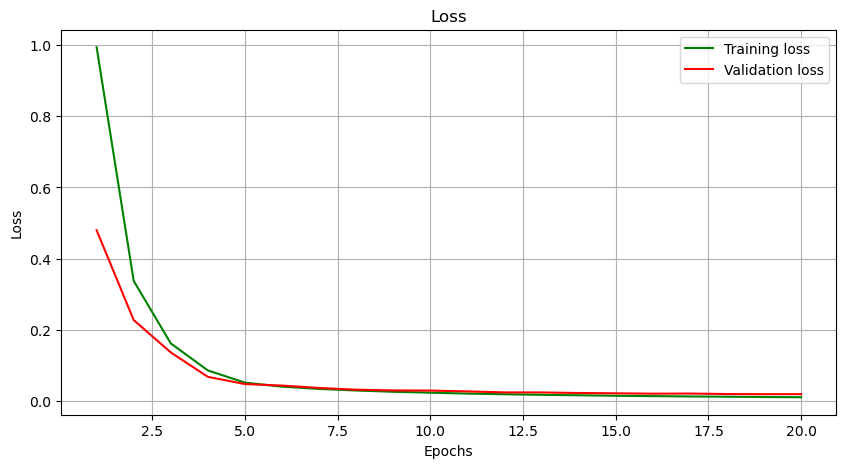

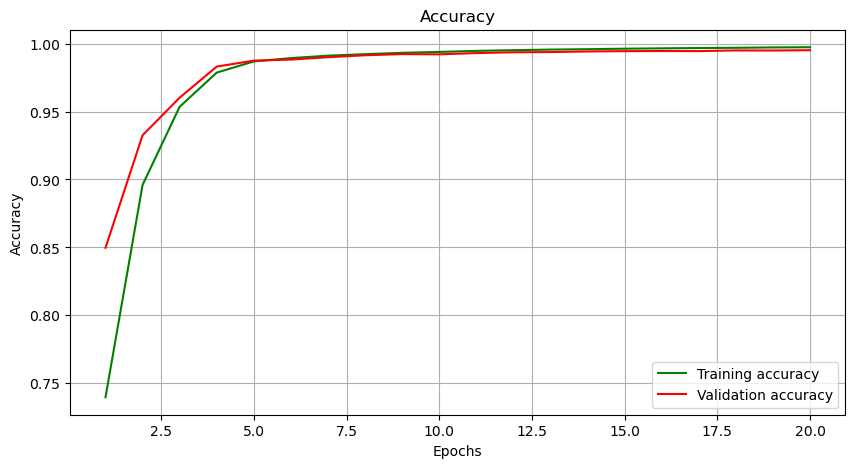

In [14]:
import matplotlib.pyplot as plt

# Sample training history data
epochs = range(1, 21)  # assuming 10 epochs
loss = trn.history['loss']
val_loss = trn.history['val_loss']
accuracy = trn.history['accuracy']
val_accuracy = trn.history['val_accuracy']

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
encoder_model = Model(encoder_inputs, encoder_states)
print(encoder_model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15)]              0         
                                                                 
 embedding (Embedding)       (None, 15, 100)           20000     
                                                                 
 lstm (LSTM)                 [(None, 100),             80400     
                              (None, 100),                       
                              (None, 100)]                       
                                                                 
Total params: 100,400
Trainable params: 100,400
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
import pickle
import os

# pickle.dump(encoder_model, open('MODELS/model_prd_enc.sav', 'wb'))

In [17]:
decoder_input_h = Input(shape=(LSTM_NEURONS,))
decoder_input_c = Input(shape=(LSTM_NEURONS,))
decoder_input_states = [decoder_input_h, decoder_input_c]

decoder_input_word = Input(shape=(1,))
decoder_input_word_emb = decoder_embedding_layer(decoder_input_word)

decoder_outputs, h, c = decoder(decoder_input_word_emb, initial_state=decoder_input_states)
decoder_states = [h, c]

outputs = output_dense_layer(decoder_outputs)

In [18]:
decoder_model = Model([decoder_input_word]+decoder_input_states, [outputs]+decoder_states)
print(decoder_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        multiple             34700       ['input_5[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                            

In [19]:
# pickle.dump(decoder_model, open('MODELS/model_prd_dec.sav', 'wb'))

In [20]:
from numpy import argmax

index_to_word_input = {v:k for k,v in inputs_word2index.items()}
index_to_word_output = {v:k for k,v in outputs_word2index.items()}

def translate(input_seq):
    states = encoder_model.predict(input_seq,verbose=0)
    
    sos = outputs_word2index['<sos>']
    eos = outputs_word2index['<eos>']
    
    output_seq = zeros((1, 1))
    output_seq[0, 0] = sos
    
    output_sentence = []
    
    for _ in range(outputs_maxlen):
        output_tokens, h, c = decoder_model.predict([output_seq]+states,verbose=0)
        idx = argmax(output_tokens[0, 0, :])
        
        if idx == eos:
            break     
        word = ''
        if idx > 0:
            word = index_to_word_output[idx]
            output_sentence.append(word)
        
        states = [h, c]
        output_seq[0, 0] = idx
    
    return ' '.join(output_sentence)

In [21]:
from numpy import random

i = random.choice(len(inputs))
input_seq = encoder_input_sequences[i:i+1]
translation = translate(input_seq)

print('Input:', inputs[i])
print('Response:', translation)

Input: he dislikes the old green automobile .
Response: il n'aime la vieille automobile verte .


In [22]:
encoder_model.save('MODELS/model_prd_enc_tf')

decoder_model.save('MODELS/model_prd_dec_tf')

INFO:tensorflow:Assets written to: MODELS/model_prd_enc_tf\assets


INFO:tensorflow:Assets written to: MODELS/model_prd_enc_tf\assets


INFO:tensorflow:Assets written to: MODELS/model_prd_dec_tf\assets


INFO:tensorflow:Assets written to: MODELS/model_prd_dec_tf\assets


In [29]:
tokenizer_file = "Tokenizers/tokenizer.pickle"
with open(tokenizer_file, 'wb') as handle:
    pickle.dump(input_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
tokenizer_file = "Tokenizers/tokenizer_fr.pickle"
with open(tokenizer_file, 'wb') as handle:
    pickle.dump(output_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# END